# Fase 3: Preparação de Dados e Busca (parte 1)

## 1. Introdução

Este relatório dá continuidade à etapa anterior de análise exploratória e compreensão da base de dados, avançando agora para a preparação dos dados e a realização de uma busca sistemática de hiperparâmetros em modelos de classificação supervisionados. Com base nas diretrizes metodológicas, o foco deste trabalho está em garantir rigor técnico e reprodutibilidade, além de maximizar o desempenho preditivo dos modelos avaliados.

Inicialmente, será apresentada uma visão geral da base de dados utilizada, retomando brevemente as principais características identificadas no relatório anterior. Em seguida, abordaremos com mais profundidade o processo de preparação dos dados, etapa fundamental para a construção de modelos consistentes. Nessa fase, serão aplicadas técnicas de normalização, além de estratégias para tratamento de valores ausentes e divisão estratificada dos dados em conjuntos de treino e teste.

A seguir, serão descritas as escolhas de modelos de classificação e os hiperparâmetros mais relevantes para cada um. Posteriormente, explicaremos o precoesso da metodologia aplicada para a busca dos hiper parâmetros.

Também será apresentado o monitoramento do desempenho durante a busca, seguido do treinamento final com os melhores parâmetros encontrados e da avaliação em conjunto de teste, utilizando métricas como acurácia, precisão, recall, F1-score e AUC-ROC. Uma análise comparativa entre os modelos será realizada, considerando aspectos como overfitting, estabilidade e desempenho geral.

Por fim, discutiremos os cuidados metodológicos aplicados ao longo de todas as etapas. Definimos como padrão uma seed para as funções e métodos que possuem uma abordagem heurística, colocando um Random State (Seed) de 51.


In [1]:
! pip install ucimlrepo -q

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
import utils.plots as plots
from utils import filter_range
from utils.checkpoint import load_checkpoint, save_checkpoint
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
import time
import random

RANDOM_STATE = 51
random.seed(RANDOM_STATE)

warnings.filterwarnings('ignore')

## 2. Base de Dados

A base de dados utilizada neste projeto é a **EEG Eye State**, previamente definida nas etapas iniciais e coletada diretamente do repositório público *UCI Machine Learning Repository*. Ela é composta por registros de sinais eletroencefalográficos (EEG) capturados por **14 eletrodos** posicionados na cabeça de um indivíduo, conforme o sistema internacional 10–20 de mapeamento. Cada linha da base representa um instante de tempo com os valores dos sinais elétricos em todos os canais e o respectivo **estado ocular (aberto = 0 ou fechado = 1)**.

#### Características Gerais

A base de dados EEG Eye State é composta por 14.980 instâncias, cada uma contendo 14 atributos contínuos que representam sinais elétricos captados por eletrodos posicionados na cabeça de um indivíduo, além de uma variável-alvo binária (`eyeDetection`) que indica se os olhos estão abertos ou fechados. Trata-se de um problema de classificação supervisionada binária com dados organizados em formato de série temporal. A ausência de valores nulos garante integridade ao conjunto, enquanto a distribuição das classes apresenta um leve desbalanceamento — cerca de 55% das amostras indicam olhos abertos e 45%, olhos fechados —, e alguns outliers muito discrepantes dos demais valores. Por fim, abaixo temos uma imagem da distribuição das classes, e da evolução temporal dos registros.

<p align="center">
  <img src="./images/distribuição.png" width="45%" style="display:inline-block; margin-right:10px;">
  <img src="./images/distribuição_perc.png" width="45%" style="display:inline-block;">
</p>

<p align="center">
  <img src="./images/evolução temporal 2.png" width="100%">
</p>

#### Relevância da Base

Essa base é amplamente utilizada em aplicações de **interface cérebro-computador**, com potencial de impacto em áreas como acessibilidade, jogos interativos, controle assistivo de dispositivos e diagnósticos em saúde. O reconhecimento automático do estado ocular, a partir de sinais cerebrais não invasivos, pode se tornar um componente essencial para sistemas de entrada alternativos — especialmente para pessoas com deficiência motora.

A estrutura do conjunto de dados e a boa qualidade dos registros possibilitaram análises detalhadas na fase anterior do projeto, como avaliação da **multicolinearidade entre canais**, **identificação e quantificação de outliers**, e **redução de dimensionalidade com PCA e t-SNE**. Tais análises forneceram as bases para as próximas etapas de preparação e modelagem, que serão conduzidas com atenção especial à preservação da integridade dos dados e à mitigação de ruídos e redundâncias.


## 3. Preparação dos dados

O carregamento da base foi feito por meio da biblioteca `ucirepo`, utilizando o identificador `id=264`, correspondente ao dataset EEG Eye State. Após o carregamento, os dados foram armazenados em dois objetos principais: `X`, contendo os atributos (sinais dos eletrodos), e `y`, contendo os rótulos (estado ocular).


In [3]:
eeg_eye_state = fetch_ucirepo(id=264)

X = eeg_eye_state.data.features
y = eeg_eye_state.data.targets

X, y = filter_range(3000, 6000, X, y)

📊 RESULTADO DA FILTRAGEM (Range: 3000 - 6000)
Dataset original: 14980 observações
Dataset filtrado: 14976 observações
Linhas removidas: 4 (0.03%)
Linhas mantidas: 99.97%



Em seguida, realizamos a divisão entre treino e teste com a função `train_test_split`, reservando 80% dos dados para o treinamento dos modelos e 20% para avaliação final. Importante destacar que utilizamos o parâmetro `stratify=y` para garantir que a proporção entre as classes fosse mantida em ambas as partições, o que é fundamental dado o leve desbalanceamento previamente identificado.

Durante o pré-processamento, inicialmente foram removidos **quatro registros** cujos valores estavam completamente fora do padrão observado. Essa decisão foi embasada por análises anteriores e reforçada por estudos semelhantes encontrados na literatura, que também desconsideraram essas amostras por representarem ruído extremo.

Após a filtragem, aplicamos normalização com o `StandardScaler`, uma vez que as distribuições dos atributos numéricos mostraram-se próximas da normal. A normalização foi ajustada exclusivamente com base no conjunto de treino, e os mesmos parâmetros foram aplicados posteriormente ao conjunto de teste, de modo a evitar data leakage.

Não foi necessário aplicar técnicas de encoding, uma vez que não há variáveis categóricas na base, nem realizar tratamentos para valores ausentes, já que o dataset é completo e consistente.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Seleção de Modelos

Para este etapa, selecionamos cinco algoritmos de classificação supervisionada com abordagens distintas e complementares: Árvore de Decisão (Decision Tree), K Vizinhos Mais Próximos (KNN), Máquinas de Vetores de Suporte (SVM), Floresta Aleatória (Random Forest) e Learning Vector Quantization (LVQ). Essa diversidade permite avaliar diferentes formas de aprendizado e generalização dos dados, otimizando as chances de encontrar um modelo de alto desempenho.

### 4.1 Decision Tree (Árvore de Decisão)

A Árvore de Decisão é um modelo baseado em regras hierárquicas que divide o espaço de atributos em regiões homogêneas por meio de perguntas binárias. É de fácil interpretação, sensível ao overfitting e bastante eficaz em bases com padrões bem definidos.

Hiperparâmetros selecionados:

- **max_depth**: este parâmetro controla a profundidade máxima da árvore. Uma profundidade maior permite que o modelo aprenda padrões mais complexos, mas aumenta o risco de overfitting. Variamos com os valores [3, 5, 10, 20, 40, 60, 100, None] para testar desde árvores mais rasas (mais generalistas) até árvores muito profundas (mais específicas).

- **min_samples_split**: define o número mínimo de amostras necessário para que um nó seja dividido. Valores maiores tendem a gerar árvores mais simples e generalistas. Utilizamos [2, 5, 10, 20, 30] para verificar como o aumento no critério de divisão impacta a complexidade do modelo.

- **min_samples_leaf**: especifica o número mínimo de amostras exigidas em uma folha. Isso ajuda a evitar folhas com poucas amostras, que podem ser muito específicas ao treino. Variamos entre [1, 2, 4, 5, 10] para testar o equilíbrio entre detalhamento e generalização.

- **criterion**: determina a função usada para medir a qualidade das divisões. Utilizamos os critérios gini (impureza de Gini) e entropy (entropia de informação) para comparar qual função melhor separa as classes nesse problema específico.

In [5]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {
    'max_depth': [3, 5, 10, 20, 40, 60, 100, None],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 5, 10],
    'criterion': ['gini', 'entropy']
}

### 4.2 K-Nearest Neighbors (KNN)

O K-Nearest Neighbors é um classificador baseado em instâncias, que prediz o rótulo de uma nova amostra com base nos rótulos das amostras mais próximas no espaço de atributos. É um modelo simples, não paramétrico e muito eficaz quando os dados apresentam uma estrutura espacial coerente.

Hiperparâmetros selecionados:

- **n_neighbors**: define o número de vizinhos considerados na votação. Valores pequenos tornam o modelo mais sensível a ruídos, enquanto valores maiores promovem maior suavização. Variamos com [1, 2, 3, 5, 7, 10, 30, 50, 100] para avaliar o impacto de k pequenos até valores maiores e mais generalistas.

- **weights**: determina se todos os vizinhos têm a mesma influência (uniform) ou se os mais próximos devem ter maior peso (distance). Essa escolha permite testar se a distância deve influenciar diretamente na predição.

- **algorithm**: especifica o algoritmo usado para encontrar os vizinhos mais próximos. Usamos ['auto', 'ball_tree', 'kd_tree', 'brute'] para permitir ao scikit-learn escolher o melhor método automaticamente ou testar diferentes abordagens de busca.

- **leaf_size**: parâmetro relevante para algoritmos baseados em árvore (kd_tree, ball_tree), influencia a velocidade de construção da árvore e tempo de consulta. Variamos entre [5, 10, 20, 30, 40, 50, 60, 100] para explorar o desempenho computacional em diferentes estruturas.

- **p**: define a potência da métrica de distância de Minkowski. Com p=1, a distância é Manhattan; com p=2, é Euclidiana. Testamos valores de [1, 2, 3, 4] para avaliar qual métrica se adapta melhor à geometria dos dados.

In [6]:
from sklearn.neighbors import KNeighborsClassifier

params_knn = {
    'n_neighbors': [1, 2, 3, 5, 7, 10, 30, 50, 100],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [5, 10, 20, 30, 40, 50, 60, 100],
    'p': [1, 2, 3, 4],
}

### 4.3 Support Vector Machine (SVM)

A Support Vector Machine (SVM) é um modelo que busca encontrar o hiperplano ótimo que melhor separa as classes no espaço de atributos, maximizando a margem entre elas. É eficaz em problemas com fronteiras complexas e se destaca por sua robustez mesmo em espaços de alta dimensão.

Hiperparâmetros selecionados:

- **C**: parâmetro de regularização que controla o trade-off entre maximizar a margem e minimizar o erro de classificação. Valores menores (0.01, 0.1) promovem uma margem mais ampla com maior tolerância a erros; valores maiores (10, 100, 1000) tentam separar as classes com mais precisão. Testamos uma ampla faixa para equilibrar generalização e performance.

- **kernel**: define a função de transformação usada para projetar os dados em um espaço de maior dimensão. Variamos entre ['linear', 'poly', 'rbf', 'sigmoid'] para comparar diferentes formas de separação, incluindo fronteiras lineares e não lineares.

- **gamma**: controla a influência de cada ponto de treinamento nas fronteiras. Valores baixos (0.001, 0.01) resultam em decisões mais suaves; valores altos (1) tornam o modelo mais sensível aos pontos individuais. Também testamos ['scale', 'auto'], que ajustam gamma automaticamente com base nas variâncias dos dados.

- **shrinking**: ativa ou desativa uma heurística de otimização que pode acelerar o processo de treinamento. Testamos True e False para verificar seu impacto no tempo e desempenho.

- **tol**: define a tolerância para os critérios de parada. Menores tolerâncias (1e-4) indicam maior precisão nas iterações, enquanto tolerâncias maiores (1e-2) aceleram o processo com menor rigor.

- **max_iter**: especifica o número máximo de iterações do otimizador. Testamos [100, 1000, 5000] para observar o comportamento da convergência sob diferentes restrições computacionais.

In [7]:
from sklearn.svm import SVC

params_svm = {
    'C': [0.01, 0.1, 1, 10, 100, 1000], 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1], 
    'shrinking': [True, False], 
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [100, 1000, 5000],
}


### 4.4 Random Forest

Random Forest é um algoritmo de ensemble baseado em múltiplas Árvores de Decisão. Cada árvore é treinada em subconjuntos diferentes dos dados e dos atributos, promovendo diversidade entre os modelos e, consequentemente, maior robustez e resistência ao overfitting.

Hiperparâmetros selecionados:

- **n_estimators**: número de árvores na floresta. Mais árvores geralmente melhoram a estabilidade e a precisão, mas aumentam o custo computacional. Testamos [50, 100, 150, 200, 250, 500] para encontrar um bom equilíbrio.

- **max_depth**: limita a profundidade de cada árvore, prevenindo overfitting. Valores como 10, 20, 30 oferecem modelos mais rasos e generalistas, enquanto None permite que a árvore cresça totalmente.

- **min_samples_split**: número mínimo de amostras necessárias para dividir um nó interno. Usamos [2, 5, 10, 20] para ajustar a granularidade das divisões.

- **min_samples_leaf**: número mínimo de amostras exigidas em cada folha. Testamos [1, 2, 4, 10] para evitar folhas com amostras isoladas, que podem causar overfitting.

- **max_features**: número máximo de atributos considerados em cada divisão. Usamos 'auto', 'sqrt', 'log2' e None para comparar estratégias de redução de variância e diversidade entre as árvores.

- **class_weight**: define pesos para as classes durante o aprendizado. None ignora o desbalanceamento; 'balanced' e 'balanced_subsample' ajustam os pesos com base na frequência das classes, uma medida importante dada a leve assimetria do dataset.

In [8]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {
    'n_estimators': [50, 100, 150, 200, 250, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20], 
    'min_samples_leaf': [1, 2, 4, 10],  
    'max_features': ['auto', 'sqrt', 'log2', None],  
    'class_weight': [None, 'balanced', 'balanced_subsample'], 
}


### 4.5 Learning Vector Quantization (LVQ)

O Learning Vector Quantization (LVQ) é um algoritmo inspirado em redes neurais competitivas. Ele utiliza vetores representativos chamados codebooks para mapear a distribuição das classes no espaço de atributos. Durante o treinamento, esses vetores são ajustados conforme a distância das amostras, aproximando-se dos pontos corretos e afastando-se dos incorretos.

Por não ser uma implementação nativa do scikit-learn, os hiperparâmetros disponíveis são definidos diretamente no construtor da classe. A seguir estão os principais parâmetros que impactam o desempenho do LVQ:

Hiperparâmetros selecionados:

- **n_codebooks**: número total de vetores protótipos (codebooks) utilizados. Esse valor afeta diretamente a capacidade de representação do modelo. Testamos [5, 10, 15, 20, 30, 50], considerando que mais codebooks permitem maior detalhamento da distribuição, mas aumentam o risco de overfitting.

- **lrate** (learning rate): taxa de aprendizado. Taxas mais altas (como 0.2, 0.5) fazem ajustes mais agressivos nos vetores, enquanto taxas mais baixas (0.01) são mais conservadoras. Avaliamos [0.01, 0.05, 0.1, 0.2, 0.5].

- **epochs**: número de passagens completas sobre o dataset. Mais épocas permitem que os protótipos se ajustem com maior precisão. Foram testados [50, 100, 200].

- **init_strategy**: define a estratégia de inicialização dos codebooks, que são os vetores protótipos responsáveis por representar as classes no espaço de atributos. Tradicionalmente, a inicialização é feita de forma aleatória, mas implementamos também a opção 'stratified_mean', que cria os codebooks a partir da média dos vetores de cada classe, promovendo uma distribuição inicial mais informada e potencialmente acelerando a convergência do modelo. Testamos as opções ['random', 'stratified_mean'] para avaliar o impacto dessa decisão sobre o desempenho e estabilidade do aprendizado.

- **distance_metric**: determina qual métrica de distância é utilizada para calcular a similaridade entre as amostras de entrada e os codebooks. Embora a distância Euclidiana ('euclidean') seja a mais comum, incluímos também a Manhattan ('manhattan') e a Chebyshev ('chebyshev') como alternativas. Essas variações permitem que o LVQ se adapte melhor à geometria dos dados, já que diferentes métricas capturam relações distintas entre atributos. A flexibilidade promovida por ['euclidean', 'manhattan', 'chebyshev'] permite analisar se o tipo de distância afeta a acurácia e a separabilidade entre as classes.

In [9]:
from utils.lvq import  LVQClassifier

params_lvq = {
    'n_codebooks': [5, 10, 20, 30, 40],
    'lrate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'epochs': [50, 75, 100],
    'init_strategy': ['random', 'stratified_mean'],
    'distance_metric': ['euclidean', 'manhattan', 'chebyshev'],
}


## 5. Metodologia

Esta seção descreve a metodologia aplicada para a escolha dos melhores hiperparâmetros e avaliação final dos modelos treinados. Todo o processo foi construído com foco na reprodutibilidade, prevenção de vazamentos de dados (data leakage), e validação criteriosa da estabilidade dos modelos.

### 5.1 Critério de Escolha

Com base na revisão da literatura realizada na primeira etapa do projeto, optamos por utilizar acurácia como métrica principal para a seleção dos modelos. Observamos que diversos estudos anteriores adotam a acurácia como referência primária de desempenho para o dataset EEG Eye State, o que reforça sua adequação para o problema em questão.

### 5.2 Busca de Hiperparâmetros

Para a busca de hiperparâmetros, utilizamos o RandomizedSearchCV, do scikit-learn, com 20 iterações para cada modelo. A validação cruzada foi feita utilizando o StratifiedKFold com 5 divisões (k=5), com estratificação das classes para manter o equilíbrio entre olhos abertos e fechados em cada partição.

A cada nova execução do RandomizedSearchCV, incrementamos o valor do random_state, garantindo que diferentes combinações de parâmetros fossem testadas. Os melhores parâmetros de cada rodada foram armazenados e posteriormente analisados por meio de um gráfico de frequência, o qual permite identificar quais combinações ou valores de parâmetros se destacaram repetidamente ao longo das buscas.

In [10]:
def search_hyperparameters(estimator, params, estm_name, metric='accuracy', n_iter=20, qnt_params=20):
    checkpoint = load_checkpoint(estm_name)
    
    best_params = checkpoint.get('best_params', [])
    total_time = checkpoint.get('total_time', 0)
    
    for i in tqdm(range(len(best_params),qnt_params), desc="Searching Hyperparameters"):
        start_time = time.time()
        
        randomized_search = RandomizedSearchCV(
            estimator,
            param_distributions=params,
            n_iter=n_iter,
            scoring=metric,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE + i),
            random_state=RANDOM_STATE + i,
            n_jobs=-1
        )
        randomized_search.fit(X_train, y_train)
        
        total_time += time.time() - start_time
        best_params.append(randomized_search.best_params_)
        save_checkpoint(estm_name, {'best_params': best_params, 'total_time': total_time})
    
    plots.plot_param_frequencies(best_params)
    print(f"Time taken for hyperparameter search: {total_time:.2f} seconds")
    return best_params

### 5.3 Análise de Estabilidade

Após obter os 20 melhores conjuntos de parâmetros para cada modelo, realizamos uma nova validação cruzada para avaliar estabilidade e robustez de cada configuração. Para isso, medimos a média e o desvio padrão da acurácia em cada um dos k-folds.

A ideia central é selecionar o modelo com maior média de desempenho entre os 25% mais estáveis (ou seja, com menor desvio padrão). Essa estratégia ajuda a evitar escolhas baseadas apenas em um bom desempenho pontual, priorizando combinações de hiperparâmetros que performam bem de forma consistente.

Durante esse processo, também plotamos a relação entre estabilidade (desvio padrão) e desempenho (média da acurácia), destacando visualmente os modelos mais promissores. Em seguida, para o modelo selecionado, plotamos a acurácia obtida em cada fold individualmente, com o objetivo de identificar flutuações ou anomalias de desempenho.

In [29]:

def cross_val_stability_analysis(estimator_class, param_list, metric='accuracy'):
    means = []
    stds = []
    all_scores = []
    for params in tqdm(param_list, desc="Cross-Validation for Params"):
        model = estimator_class(**params)
        scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring=metric)
        means.append(np.mean(scores))
        stds.append(np.std(scores))
        all_scores.append(scores)

    # Separar modelos mais estáveis (menor desvio padrão)
    stability_threshold = np.percentile(stds, 25)
    stable_idxs = [i for i, s in enumerate(stds) if s <= stability_threshold]
    unstable_idxs = [i for i, s in enumerate(stds) if s > stability_threshold]

    # Plot separando estáveis e instáveis
    plots.plot_stability_vs_metric(stds, means, stable_idxs, unstable_idxs, metric)

    # Selecionar o modelo mais estável com maior média da métrica
    best_idx = max(stable_idxs, key=lambda i: means[i]) if stable_idxs else np.argmax(means)
    best_params = param_list[best_idx]
    best_scores = all_scores[best_idx]

    # Plot da métrica em cada fold para o melhor modelo
    plots.plot_metric_per_fold(best_scores, metric)

    return best_params


### 5.4 Avaliação Final dos Modelos

Com o modelo mais estável e com melhor desempenho médio escolhido, passamos para a fase final de avaliação. Essa etapa envolve tanto o conjunto de treinamento quanto o conjunto de teste, e tem como objetivo verificar a capacidade de generalização do modelo e identificar sinais de overfitting.

A primeira análise consiste em um treinamento progressivo: iniciamos com 20% do conjunto de treino e aumentamos o tamanho gradualmente em incrementos de 5%, até alcançar os 100%. Em cada etapa, medimos a métrica escolhida (acurácia, F1, precisão ou recall) tanto no treino quanto no teste. Essa análise permite visualizar se o modelo continua melhorando no teste à medida que recebe mais dados ou se passa a superajustar (overfitting) ao conjunto de treino.

Em seguida, treinamos o modelo completo com os melhores parâmetros e realizamos:
- Matriz de confusão para visualizar os erros de classificação por classe;
- Curva ROC e cálculo da AUC para medir a capacidade discriminativa do modelo;
- Cálculo das principais métricas (acurácia, F1-score, precisão e recall) separadamente para treino e teste.

As métricas e visualizações obtidas nessa etapa final são utilizadas para comparação entre os diferentes modelos testados (Decision Tree, KNN, SVM, Random Forest, LVQ), permitindo avaliar não apenas qual modelo teve a melhor performance bruta, mas também qual apresentou maior equilíbrio entre desempenho e robustez.

In [12]:
def evaluate_and_plot(params, model_class, metric='accuracy', model_name=None):
    
    model = model_class(**params, random_state=RANDOM_STATE) if 'random_state' in model_class().get_params() else model_class(**params)
    train_scores, test_scores = [], []
    percents = np.arange(0.2, 1.01, 0.05)
    scorer = {
        'accuracy': accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score
    }[metric]
    for p in percents:
        n = int(p * len(X_train))
        model.fit(X_train[:n], y_train[:n])
        y_pred_train = model.predict(X_train[:n])
        y_pred_test = model.predict(X_test)
        train_scores.append(scorer(y_train[:n], y_pred_train))
        test_scores.append(scorer(y_test, y_pred_test))
        
    
    plots.plot_metric_evolution(percents, train_scores, test_scores, metric)

    # Treinamento completo
    model = model_class(**params, random_state=RANDOM_STATE) if 'random_state' in model_class().get_params() else model_class(**params)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    plots.plot_confusion_matrix(y_test, y_pred_test, model_class.__name__)

    auc_score = plots.plot_roc_curve(model, X_test, y_test, model_class.__name__)

    metrics_dict = {
        "accuracy_train": accuracy_score(y_train, y_pred_train),
        "accuracy_test": accuracy_score(y_test, y_pred_test),
        "f1_train": f1_score(y_train, y_pred_train),
        "f1_test": f1_score(y_test, y_pred_test),
        "precision_train": precision_score(y_train, y_pred_train),
        "precision_test": precision_score(y_test, y_pred_test),
        "recall_train": recall_score(y_train, y_pred_train),
        "recall_test": recall_score(y_test, y_pred_test),
        "auc": auc_score
    }
    
    if model_name is None:
        model_name = model_class.__name__
    
    plots.plot_main_metrics(metrics_dict, model_name)

    return metrics_dict

### 5.5 Cuidados Metodológicos

Durante toda a execução da metodologia, foram adotados cuidados fundamentais para garantir validade e reprodutibilidade dos resultados:

- **Prevenção de data leakage**: todos os pré-processamentos foram ajustados exclusivamente no conjunto de treino e aplicados posteriormente no teste.

- **Validação estratificada**: todas as validações cruzadas respeitaram a distribuição original das classes.

- **Reprodutibilidade**: o parâmetro random_state foi definido e documentado em todas as etapas que envolvem aleatoriedade.

- **Eficiência computacional**: utilizamos n_jobs = -1 para paralelização da busca, além de RandomizedSearchCV em vez de GridSearchCV, visando economia de tempo em espaços de busca extensos.

- **Interpretação criteriosa**: múltiplas métricas foram analisadas e cruzadas entre treino e teste para identificar possíveis problemas de variância, viés ou generalização.

## 6. Busca e Avaliação de Hiper Parâmetros

### 6.1 Decision Tree (Árvore de Decisão)

A busca pelos 20 melhores conjuntos de hiperparâmetros para o modelo de Árvore de Decisão foi a mais rápida entre todos os modelos testados, com tempo total de 25.22 segundos. Isso demonstra a leveza computacional desse algoritmo.

Em relação aos hiperparâmetros otimizados:

- **min_samples_split**: A maior frequência se concentrou nos valores 2 e 5, com leve predominância do 2. Isso indica uma tendência do modelo em preferir divisões mais agressivas, o que está associado a árvores mais profundas.

- **min_samples_leaf**: Os valores mais frequentes foram 1 e 2, novamente refletindo uma tendência para folhas pequenas, o que potencializa o overfitting, mas pode ser desejável em problemas com padrões bem definidos.

- **max_depth**: O valor 20 foi o mais escolhido, enquanto valores como 40, 60 e 100 também apareceram com menor frequência. A presença do valor None (sem restrição) foi rara ou ausente.

- **criterion**: O critério entropy teve ampla predominância sobre o gini, sugerindo que o modelo se beneficiou da divisão baseada em ganho de informação.

Abaixo, a distribuição dos hiperparâmetros mais frequentes:

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

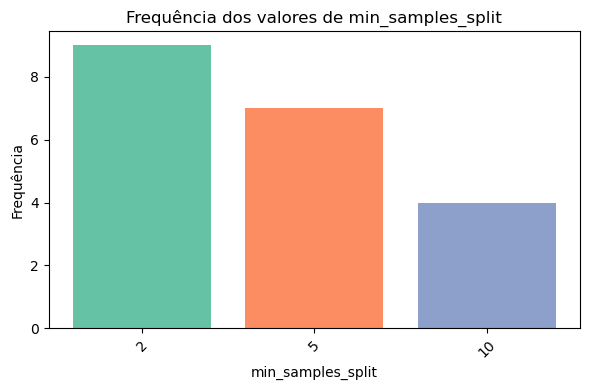

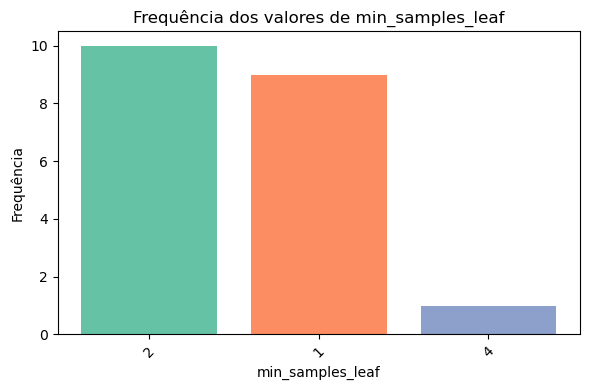

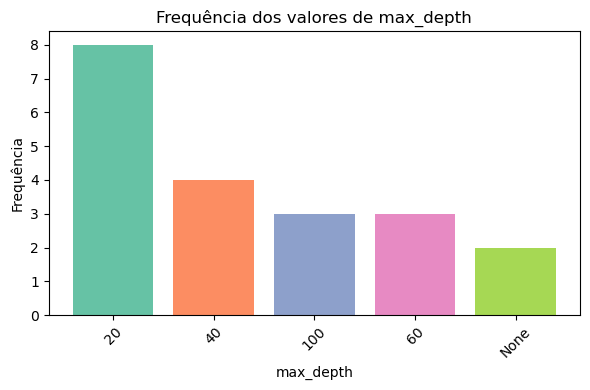

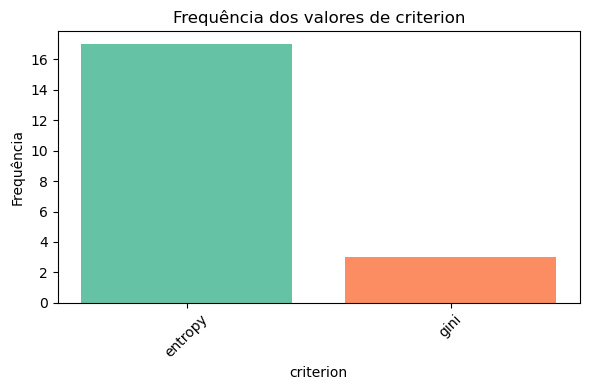

Time taken for hyperparameter search: 25.22 seconds


In [13]:
best_params_dt = search_hyperparameters(DecisionTreeClassifier(), params_dt,'dt' ,metric='accuracy')


Durante a análise de estabilidade via validação cruzada dos 20 melhores conjuntos, apenas 4 foram considerados estáveis, ou seja, apresentaram baixa variação entre as métricas nas diferentes dobras. Isso indica que o modelo de árvore de decisão, embora rápido, apresenta alta sensibilidade às divisões dos dados — um sinal comum de overfitting. O modelo selecionado para a etapa final não foi o de melhor média geral, mas sim o segundo melhor, pois este foi o mais estável entre os que apresentaram desempenho competitivo. Essa escolha equilibrada priorizou robustez em relação à generalização, em vez de apenas acurácia máxima. Abaixo temos um gráfico que mostra a estabilidade de cada modelo e a acurácia do modelo escolhido ao logo de cada k-fold.

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

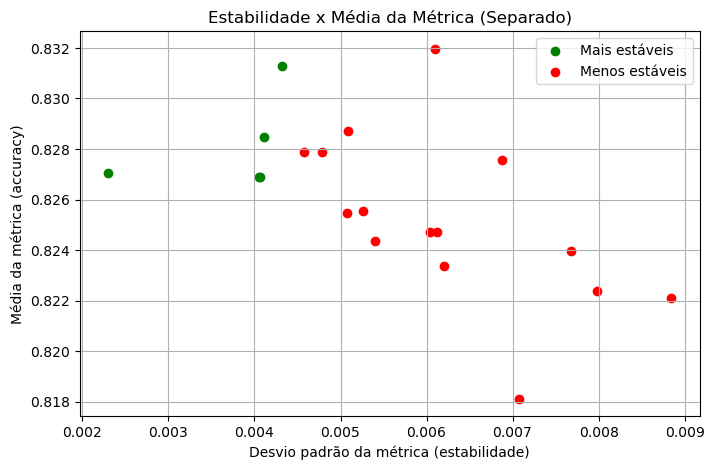

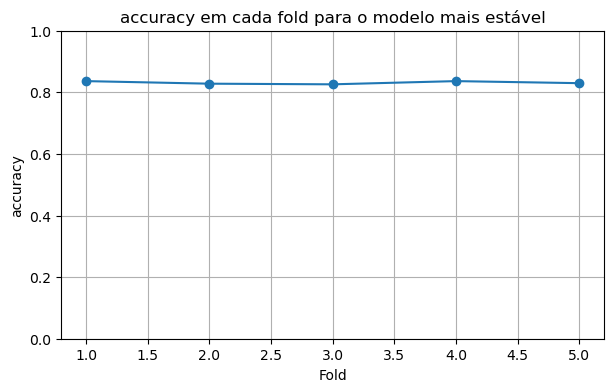

In [14]:
best_param_dt = cross_val_stability_analysis(DecisionTreeClassifier, best_params_dt, metric='accuracy')

A seguir, as métricas obtidas pelo melhor modelo selecionado:

| Métrica            | Treino | Teste |
| ------------------ | ------ | ----- |
| Acurácia           | 1.00   | 0.842 |
| F1-score           | 1.00   | 0.825 |
| Precisão           | 1.00   | 0.821 |
| Revocação (Recall) | 1.00   | 0.829 |
| AUC                | —      | 0.841 |

O modelo claramente sofreu de **overfitting severo**, com performance perfeita no treino, mas consideravelmente inferior no teste. Ainda assim, apresentou desempenho acima de 82% em todas as métricas principais de teste, o que demonstra certo potencial.

A curva de aprendizado abaixo mostra como a **acurácia de teste melhora conforme mais dados são utilizados**, enquanto a de treino permanece em 1.0 — evidência clara de que o modelo decorou o conjunto de treinamento:

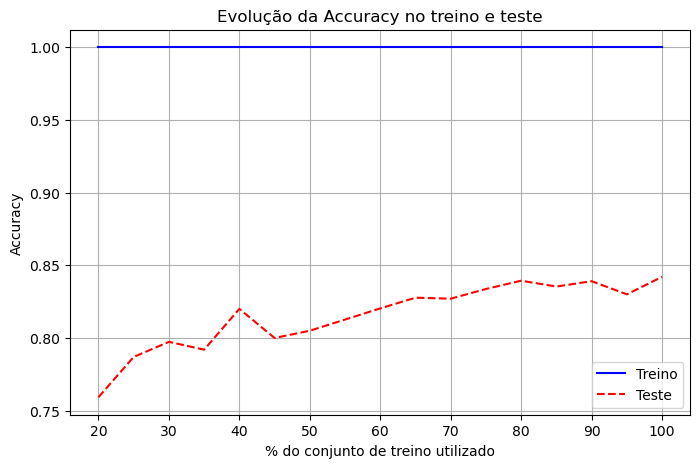

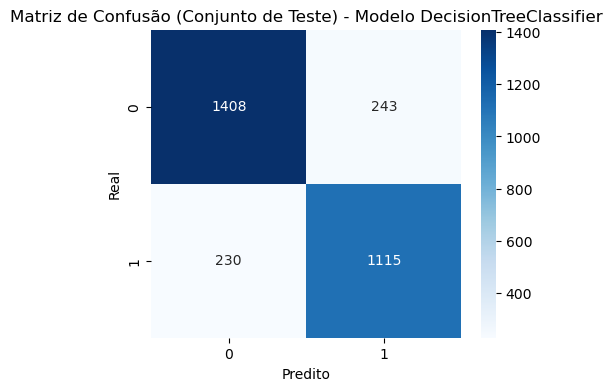

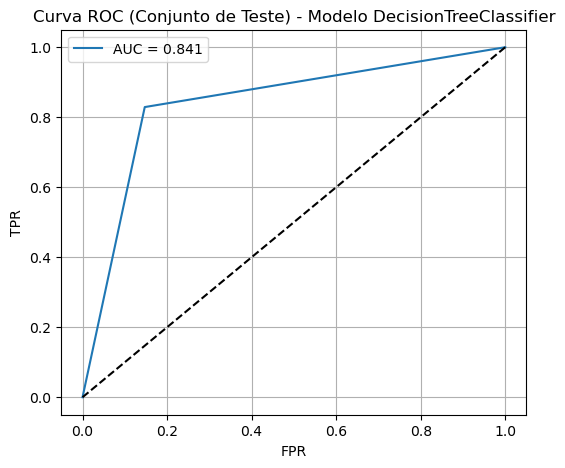

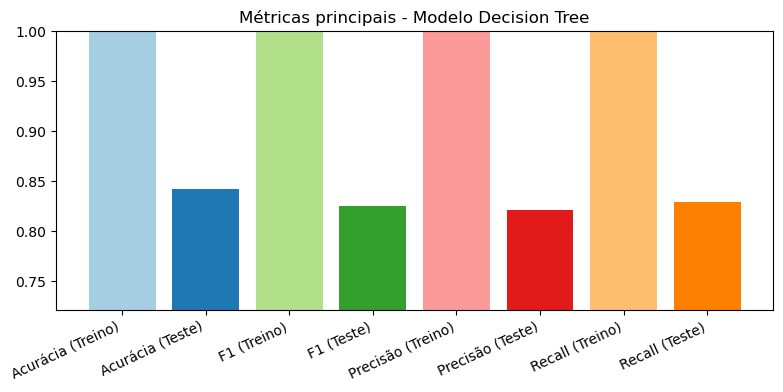

In [15]:
results_dt = evaluate_and_plot(best_param_dt, DecisionTreeClassifier, metric='accuracy', model_name='Decision Tree')

### 6.2 K-Nearest Neighbors (KNN)

A busca pelos melhores hiperparâmetros do modelo KNN levou um tempo total de 51.38 segundos, sendo ligeiramente superior ao tempo da Árvore de Decisão. O KNN apresenta uma variedade maior de combinações possíveis, principalmente devido à sensibilidade dos parâmetros p e n_neighbors.

Nos 20 melhores resultados obtidos, 17 configurações distintas foram encontradas. Abaixo destacam-se os comportamentos observados:

- **weights**: O valor distance apareceu com muita frequência, sendo escolhido em 15 das 20 execuções. Isso sugere que dar maior peso aos vizinhos mais próximos melhora a performance do modelo neste caso.

- **p** (métrica de distância): Os valores mais frequentes foram 1, 2 e 3, com destaque para p=2 (distância euclidiana) e p=1 (manhattan), demonstrando que diferentes métricas são viáveis, embora p=2 ainda seja padrão.

- **n_neighbors**: O modelo mostrou forte preferência por valores baixos, especialmente n_neighbors=1, que apareceu em 12 dos 20 modelos, indicando um comportamento de alta sensibilidade local.

- **leaf_size**: Embora varie amplamente (de 5 a 100), a faixa entre 30 e 60 apareceu com maior frequência. Este parâmetro afeta a performance, mas não a acurácia diretamente.

- **algorithm**: O algoritmo mais frequente foi brute, seguido de ball_tree e kd_tree. Isso sugere que, com poucas amostras ou k baixos, o brute-force pode ser mais confiável que estruturas otimizadas.

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

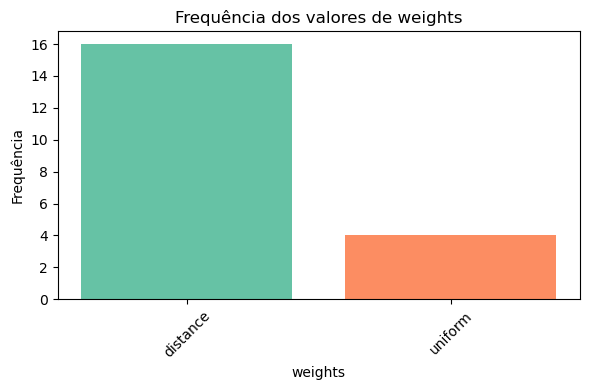

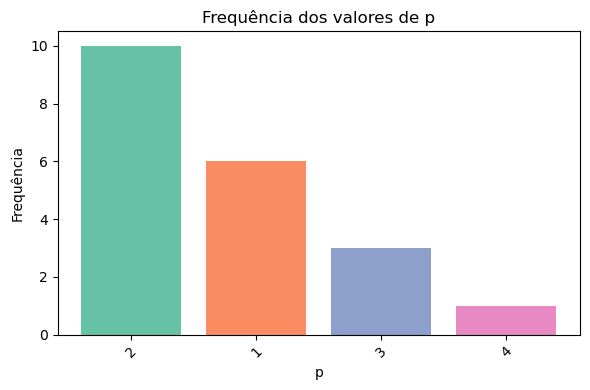

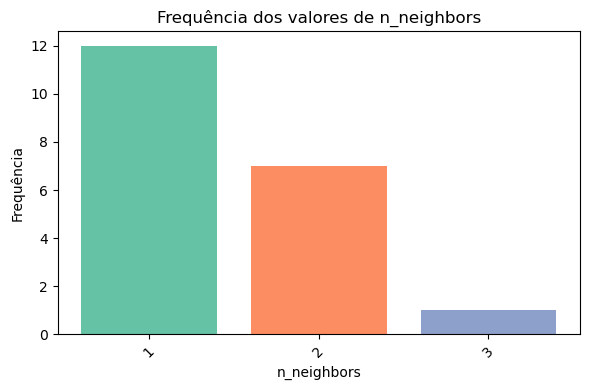

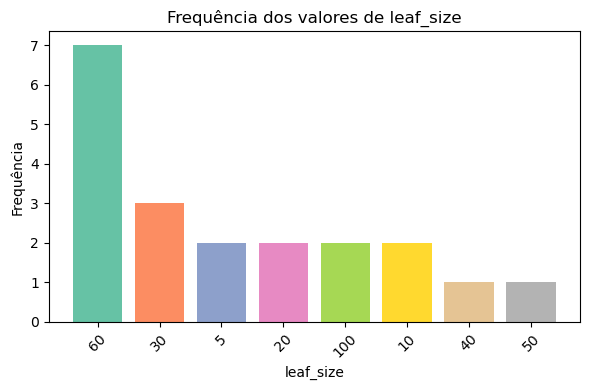

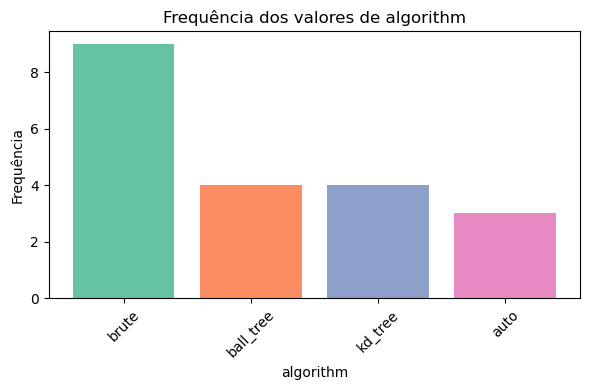

Time taken for hyperparameter search: 422.77 seconds


In [17]:
best_params_knn = search_hyperparameters(KNeighborsClassifier(), params_knn, 'knn', metric='accuracy')

Dos 20 modelos, observou-se que os mais estáveis não eram necessariamente os de maior média de desempenho, mas a diferença entre os melhores foi muito pequena (cerca de 0.2%), indicando que o KNN apresenta baixa variabilidade entre dobras, sendo relativamente robusto à escolha dos dados de validação.

O modelo selecionado como final possuía os seguintes parâmetros:
- p = 3
- n_neighbors = 1
- leaf_size = 30
- algorithm = ball_tree
- weights = distance

Esse modelo ficou entre os melhores em média e apresentou ótima estabilidade.

Abaixo temos um gráfico que mostra a estabilidade de cada modelo e a acurácia do modelo escolhido ao longo de cada k-fold:

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

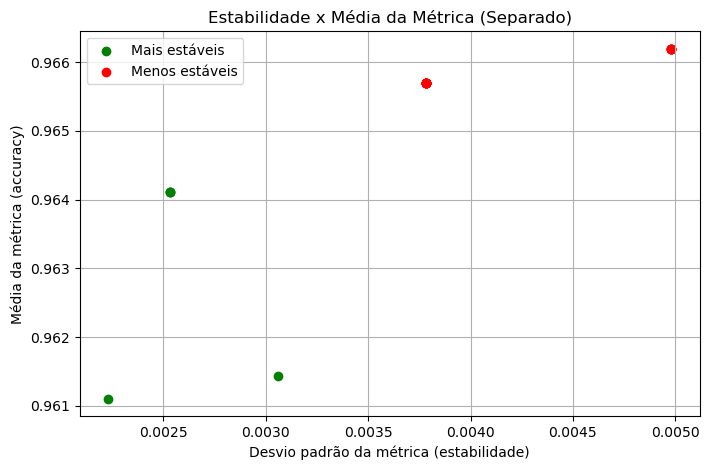

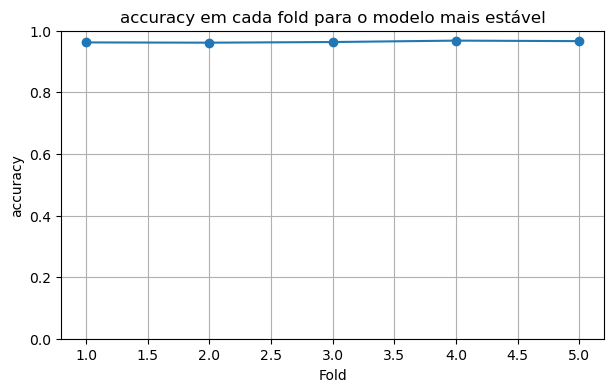

In [18]:
best_param_knn = cross_val_stability_analysis(KNeighborsClassifier, best_params_knn, metric='accuracy')

| Métrica            | Treino | Teste |
| ------------------ | ------ | ----- |
| Acurácia           | 1.00   | 0.965 |
| F1-score           | 1.00   | 0.962 |
| Precisão           | 1.00   | 0.955 |
| Revocação (Recall) | 1.00   | 0.968 |
| AUC                | —      | 0.966 |

Apesar da acurácia perfeita no treino indicar possível overfitting, o KNN teve desempenho extremamente alto no teste, com mínimas perdas de performance, o que mostra que o modelo conseguiu generalizar muito bem.

A curva de aprendizado reforça isso: a acurácia de teste aumenta de forma consistente com o aumento dos dados de treino, mostrando que o modelo ainda estava se beneficiando da adição de exemplos.

Na análise da matriz de confusão, foi observado que o modelo teve 18 classificações a mais incorretas na classe "Real=0, Predito=1", o que pode indicar uma leve tendência à classificação de falsos positivos, isso pode ser resultado também do desbalanceamento de dados.

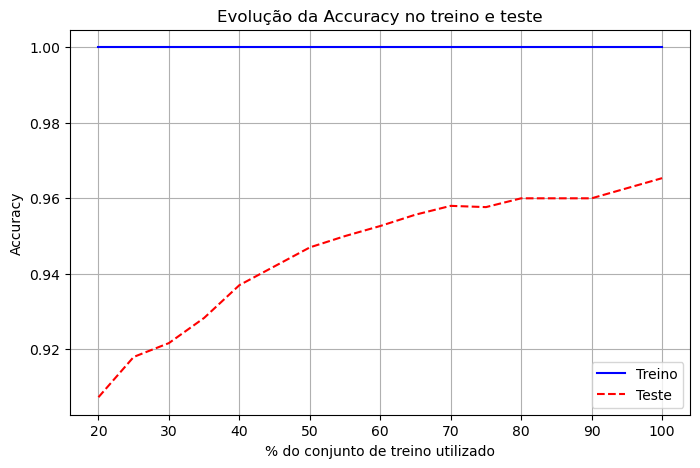

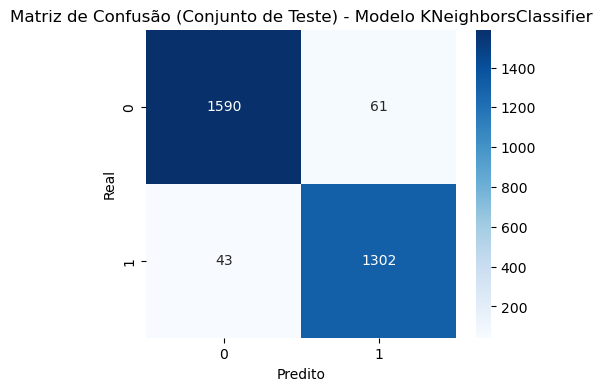

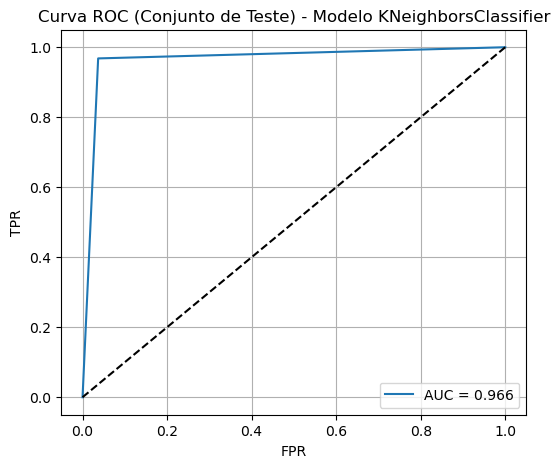

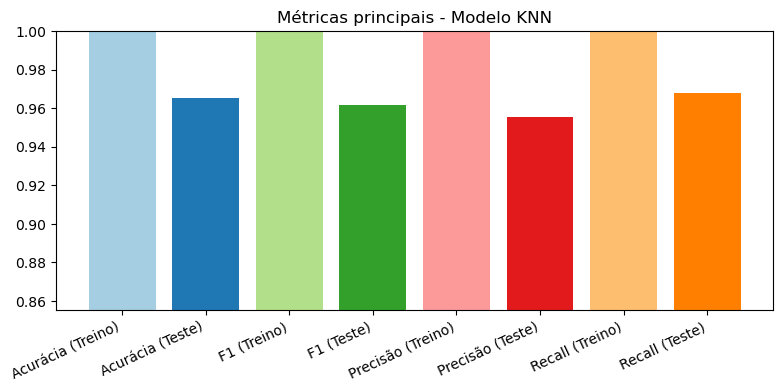

In [19]:
results_knn = evaluate_and_plot(best_param_knn, KNeighborsClassifier, metric='accuracy', model_name='KNN')

### 6.3 Support Vector Machine (SVM)

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

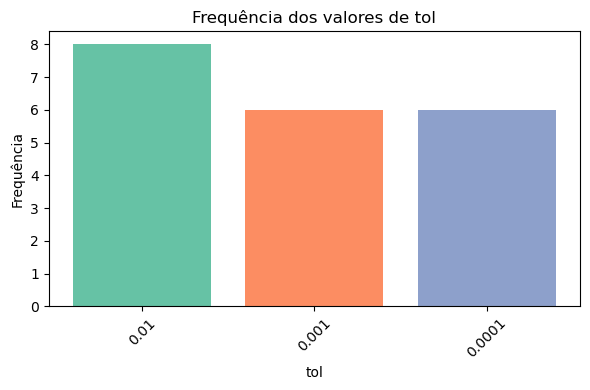

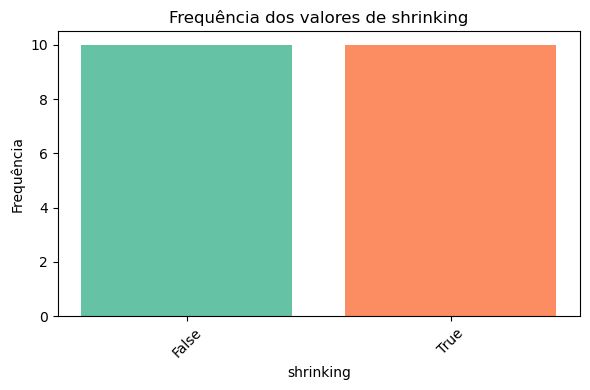

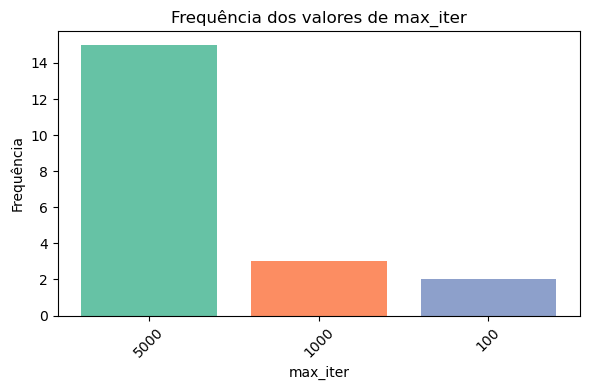

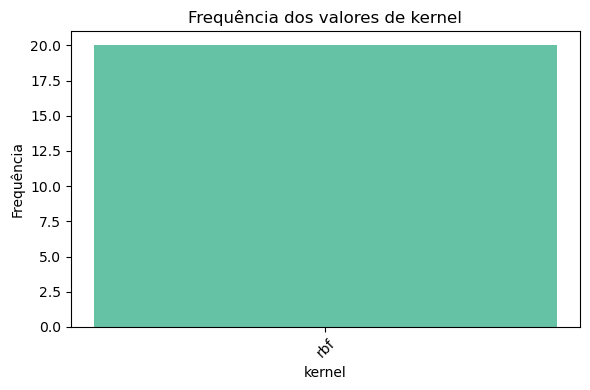

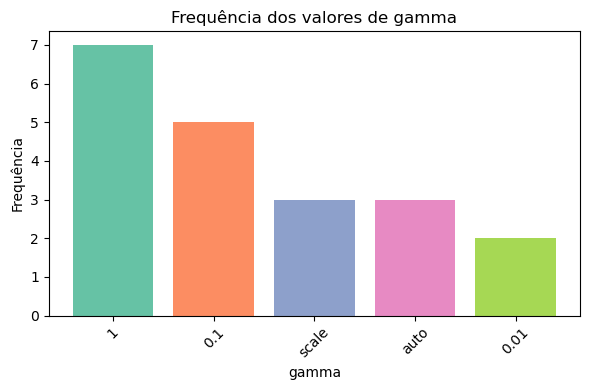

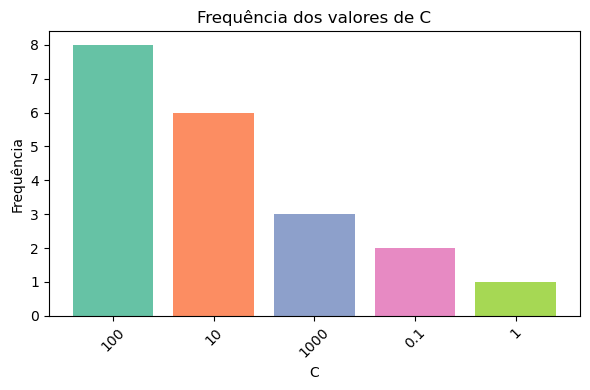

Time taken for hyperparameter search: 292.08 seconds


In [20]:
best_params_svm = search_hyperparameters(SVC(), params_svm,'svm', metric='accuracy')

In [37]:
best_param_rf

{'n_estimators': 250,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'class_weight': 'balanced_subsample'}

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

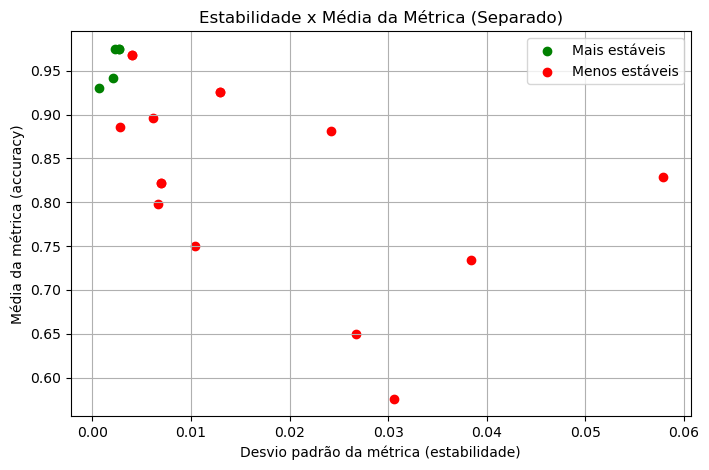

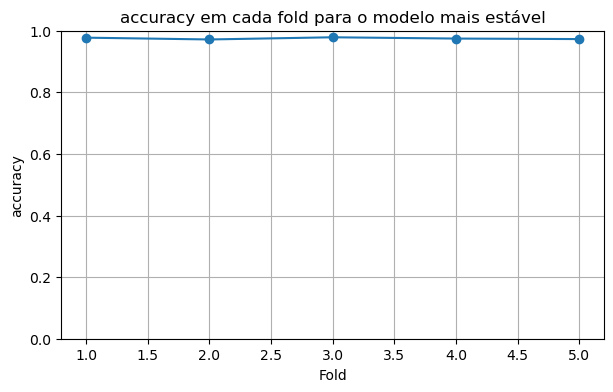

In [21]:
best_param_svm = cross_val_stability_analysis(SVC, best_params_svm, metric='accuracy')

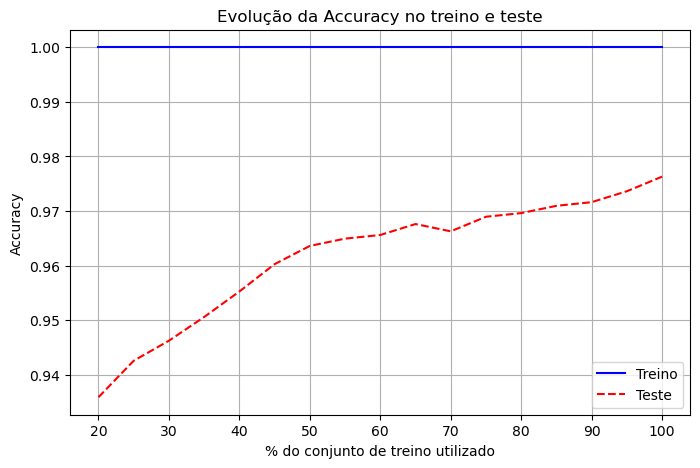

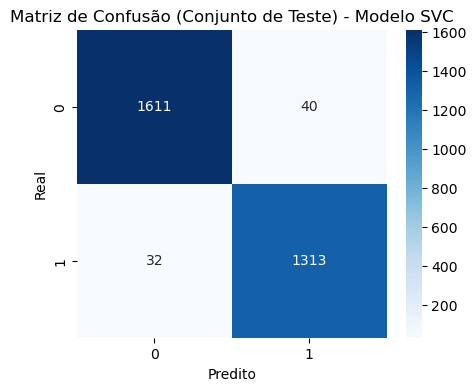

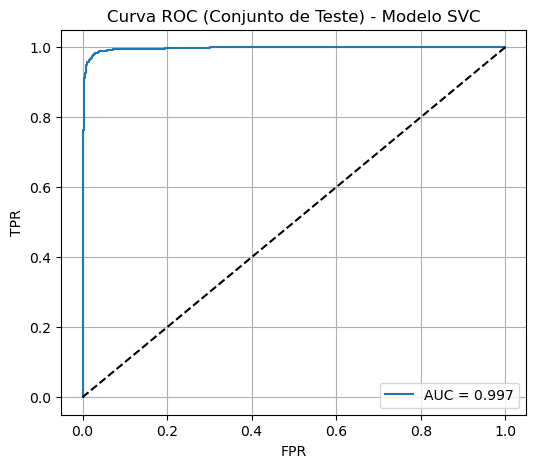

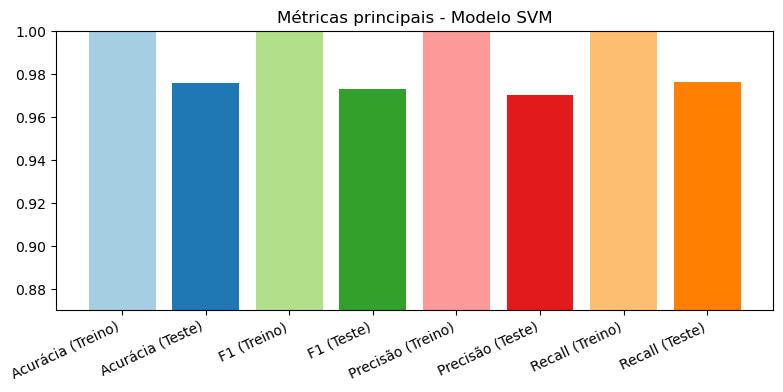

In [22]:
results_svm = evaluate_and_plot(best_param_svm, SVC, metric='accuracy', model_name='SVM')

### 6.4 Random Forest

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

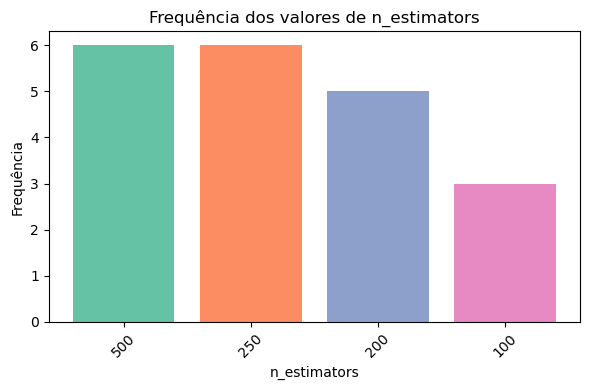

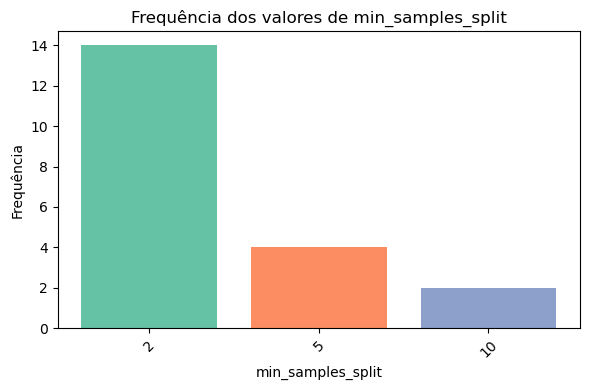

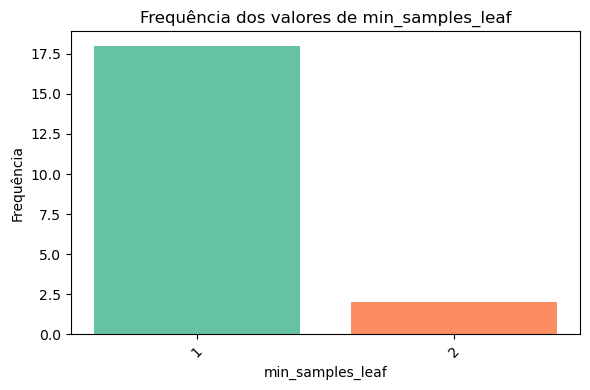

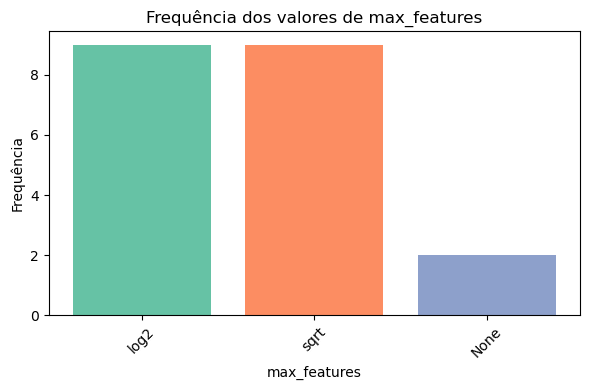

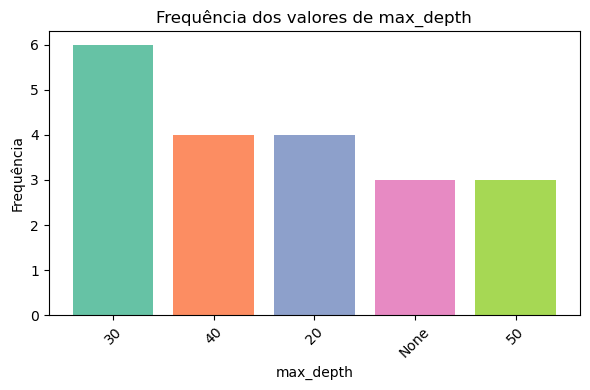

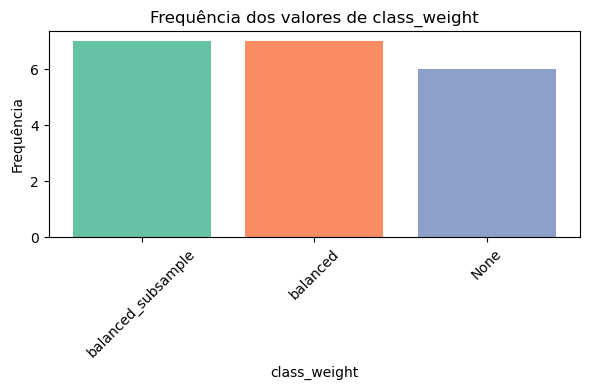

Time taken for hyperparameter search: 1061.77 seconds


In [23]:
best_params_rf = search_hyperparameters(RandomForestClassifier(), params_rf, 'rf', metric='accuracy')

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

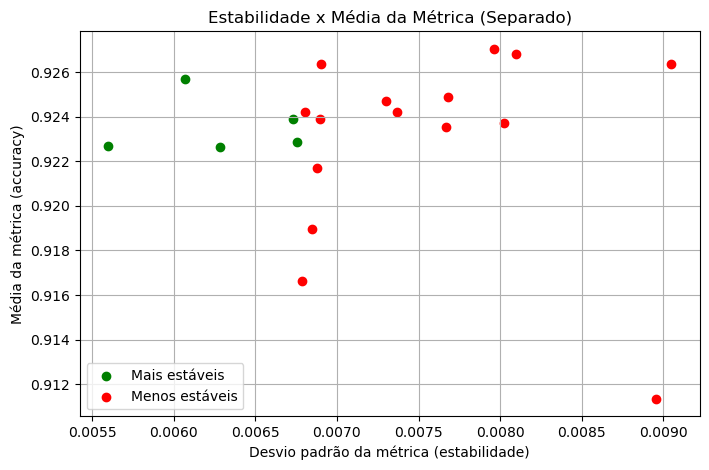

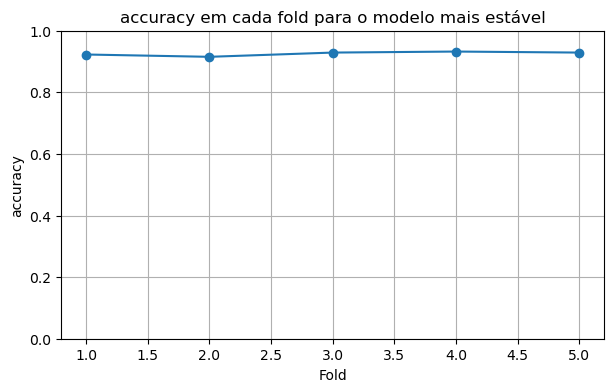

In [24]:
best_param_rf = cross_val_stability_analysis(RandomForestClassifier, best_params_rf, metric='accuracy')

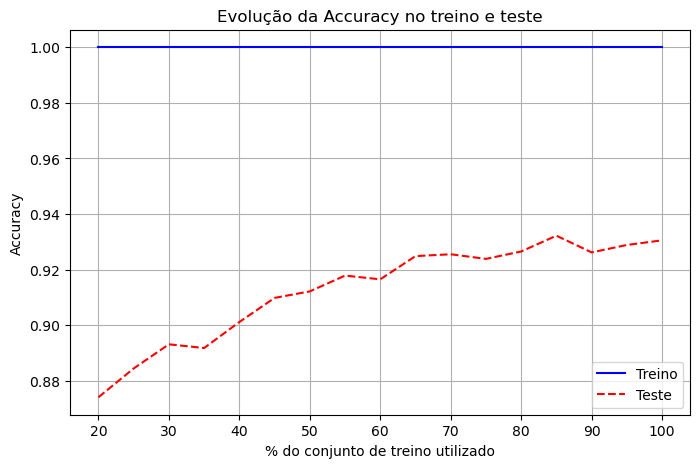

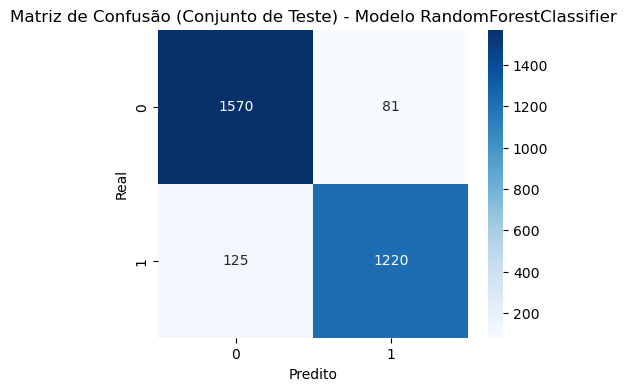

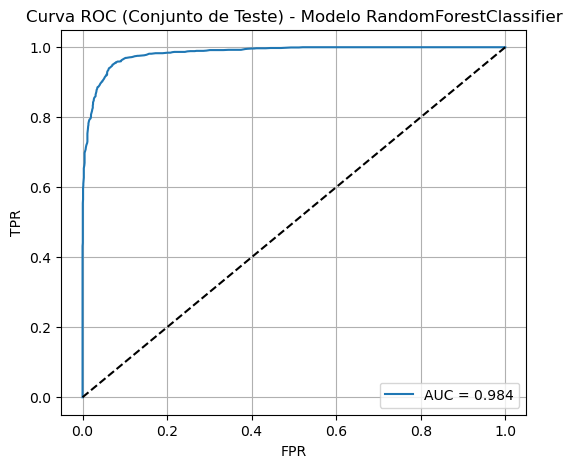

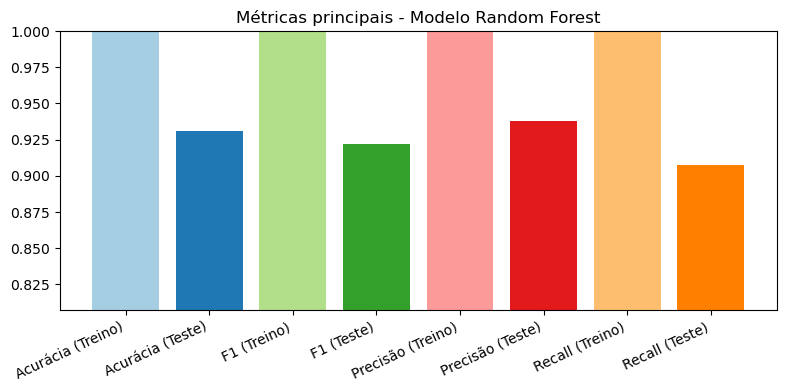

In [25]:
results_rf = evaluate_and_plot(best_param_rf, RandomForestClassifier, metric='accuracy', model_name='Random Forest')

### 6.5 Learning Vector Quantization (LVQ)

Searching Hyperparameters:   0%|          | 0/8 [00:00<?, ?it/s]

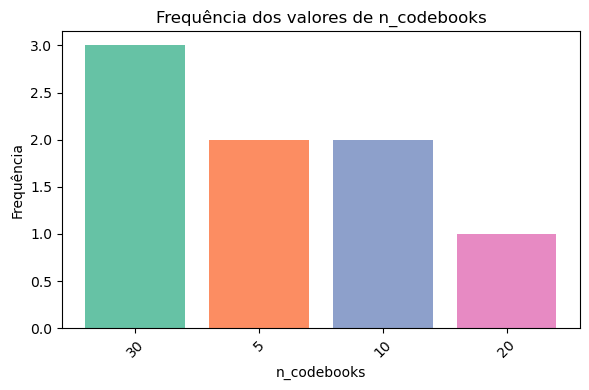

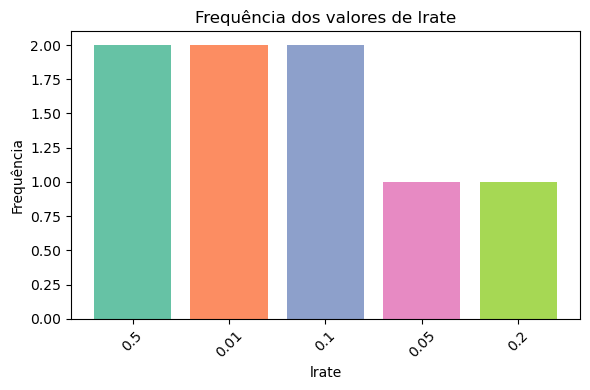

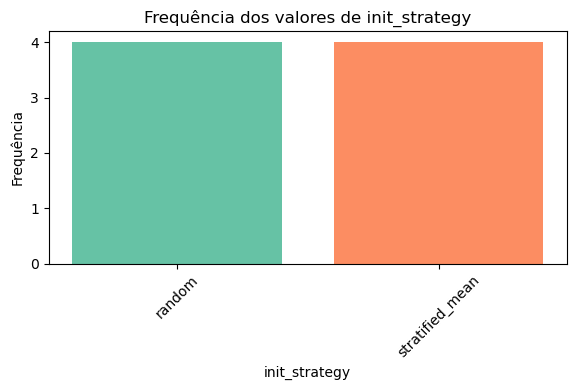

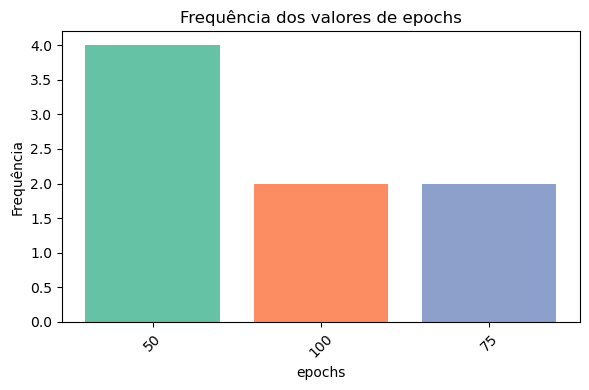

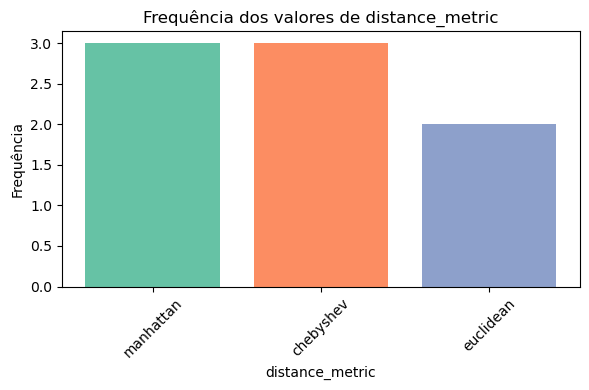

Time taken for hyperparameter search: 5004.63 seconds


In [26]:
best_params_lvq = search_hyperparameters(LVQClassifier(), params_lvq,"lvq",  metric='accuracy', n_iter=10, qnt_params=8)

Cross-Validation for Params:   0%|          | 0/8 [00:00<?, ?it/s]

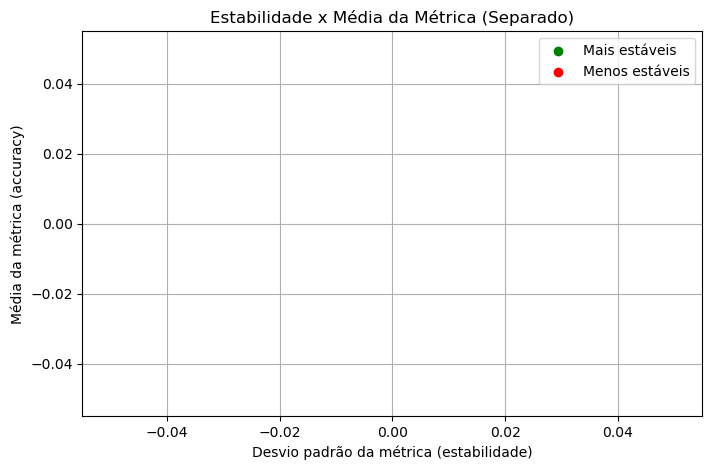

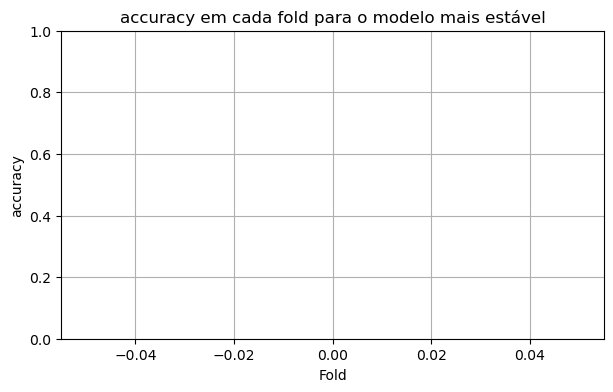

In [33]:
best_param_lvq = cross_val_stability_analysis(LVQClassifier, best_params_lvq, metric='accuracy')

In [38]:
results_lvq = evaluate_and_plot(best_param_lvq, LVQClassifier, metric='accuracy', model_name='LVQ')

ValueError: operands could not be broadcast together with shapes (14,) (13,) 

In [32]:
import pandas as pd

results_dt['model'] = 'Decision Tree'
results_knn['model'] = 'KNN'
results_svm['model'] = 'SVM'
results_rf['model'] = 'Random Forest'
# results_lvq['model'] = 'LVQ'

df = pd.DataFrame([
    results_dt, results_knn, results_svm, results_rf
])

df

,accuracy_train,accuracy_test,f1_train,f1_test,precision_train,precision_test,recall_train,recall_test,auc,model
0,1.0,0.842123,1.0,0.825009,1.0,0.821060,1.0,0.828996,0.840906,Decision Tree
1,1.0,0.965287,1.0,0.961595,1.0,0.955246,1.0,0.968030,0.965541,KNN
2,1.0,0.975968,1.0,0.973314,1.0,0.970436,1.0,0.976208,0.996729,SVM
3,1.0,0.931242,1.0,0.922147,1.0,0.937740,1.0,0.907063,0.983508,Random Forest
